<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: 1.0 Data preprocessing and EDA

> Authors: Pius Yee

## Introduction

Automated Teller Machines (ATMs) have become an essential part of our daily lives, providing convenient access to cash. However, their reliance on physical cards and PINs makes them vulnerable to theft. Techniques like ATM skimming, where fraudsters steal card information and PINs, pose a significant threat to both financial institutions and consumers. These stolen credentials can be used to withdraw money illegally, leaving victims with financial losses and a sense of insecurity.

This project aims to address these security concerns by proposing a novel approach that leverages existing ATM camera infrastructure. By implementing a system that analyzes video footage and predicts a user's age, gender, and race, we can introduce an additional layer of security. This information, when compared with the cardholder's details on file, can potentially identify suspicious activity and trigger alerts to the cardholder or bank in real-time.

ATM skimming is occurring worldwide, with instances reported in various countries, including the US and Australia.

Articles:
- [News - KTNV Las Vegas](https://www.ktnv.com/news/skimmers-targeting-ebt-cards-atm-transactions-found-across-las-vegas-nationwide)

- [ABC News Australia](https://www.abc.net.au/news/2023-08-13/qld-alleged-atm-skimming-scam-busted/102724094)

---
## Persona

Sarah is living in a city where the ATM skimming incidents are rising rapidly.

She relies on ATMs for quick cash access but expects a secure and efficient experience. With the rise of ATM-related scams, she worries that using an ATM might expose her card details or PIN. She feels particularly unsafe when using ATMs in isolated locations, where the risk of skimming might be higher. Sarah wants her bank to take proactive measures to protect her financial information.

---
## Problem Statement

How can we utilize facial recognition technology to provide additional security for bank customers?

---

## Approach

This new system should be able to:

- Analyze video footage captured by ATM cameras.
- Predict the age, gender, and race of the ATM user with a high degree of accuracy.
- Compare this predicted information with the cardholder's details on file.
- Identify discrepancies between predicted user characteristics and cardholder information that might suggest suspicious activity.
- Trigger real-time alerts to the cardholder or bank in case of potential fraud.

In order to do this, I will construct three models to detect demographics from faces:

1) `Gender Classification Model`: Determines whether the individual is male or female.

2) `Race Classification Model`: Identifies the ethnicity, such as white, Asian, black, etc.

3) `Age Classification Model`: Estimates the age of the individual.

*Using these models, we can ascertain demographic information from faces. Subsequently, we will integrate the three models into a face recognition system:*

4) `Face detection Model`: Recognizes faces from video footage and utilizes the aforementioned three models to determine demographic characteristics.


---
##### In Notebook 1.0, I will clean and process the raw image data to gain a better understanding of it. Additionally, I will employ Exploratory Data Analysis (EDA) techniques to gain further insight into the data.

##### The raw data utilized for this project is the `UTKFace` dataset. It is a large-scale face dataset encompassing a wide age range, from 0 to 116 years old. The dataset comprises over 20,000 face images annotated with age, gender, and ethnicity. 

In [1]:
# Import libraries

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread

import cv2

## 1. Extracting info from dataset

The labels of each face image are embedded in the file name, formatted as [age][gender][race]_[date&time].jpg.

[`age`] is an integer ranging from 0 to 116, representing the age.

[`gender`] is either 0 (male) or 1 (female).

[`race`] is an integer from 0 to 4, indicating White, Black, Asian, Indian, and Others (such as Hispanic, Latino, Middle Eastern).

[`date&time`] is in the format of yyyymmddHHMMSSFFF, indicating the date and time the image was collected for the UTKFace dataset.

For example, the image filename "34_0_0_20170117141513036.jpg.chip.jpg" is age 34, male and white.

### 1.1 Creating a dataframe

Firstly, I will create a dataframe to store the age, gender and race from the dataset.

In [2]:
# define a function to get the label
# for example, filename "32_0_1_20170113183229559.jpg" is age 32, male and black

def extract_info_from_filename(filename):
    age, gender, race, _ = filename.split("_")
    return age, gender, race

In [3]:
# test the function on a random filename:-
# outout is age, gender and race

extract_info_from_filename("32_0_1_20170113183229559.jpg")

('32', '0', '1')

In [4]:
# extract age, gender and race from the images with the function above,
data_dir = "../datasets/utkface"

# save the age, gender and race from the filename to lists
img = []
age_labels = []
gender_labels = []
race_labels = []

# apply the function to all images in the dataset
for filename in os.listdir(data_dir):
    if filename.endswith(".jpg") and len(filename.split("_")) == 4:
        # Extract information from filename
        age, gender, race = extract_info_from_filename(filename)

        # Append to lists
        img.append(filename)
        age_labels.append(age)
        gender_labels.append(gender)
        race_labels.append(race)                

In [5]:
# create a dataframe for the data using the extracted info
df_main = pd.DataFrame(data=[img,age_labels,gender_labels,race_labels]).T
df_main.columns= ['filename','age','gender','race']
df_main.head()

,filename,age,gender,race
0,9_1_2_20161219204347420.jpg.chip.jpg,9,1,2
1,36_0_1_20170117163203851.jpg.chip.jpg,36,0,1
2,86_1_0_20170120225751953.jpg.chip.jpg,86,1,0
3,26_1_0_20170116171048641.jpg.chip.jpg,26,1,0
4,1_1_2_20161219154612988.jpg.chip.jpg,1,1,2


In [6]:
# checking for missing value or anomalies

df_main.isnull().sum()

filename    0
age         0
gender      0
race        0
dtype: int64

No missing value found.

### 1.2 Data pre-processing

Now I have the dataframe with the info for the dataset.

For the age column, I will group it into different age group for the model training.

In [7]:
# build a new column for the age bucket
ranges = [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70), (71, 120)]

# convert age to integer
df_main.age = df_main.age.astype("int")


# Create a function to map ages to ranges
def map_to_range(age):
  for start, end in ranges:
    if start <= int(age) <= end:
      return f"{start}-{end}"
  return "NA"  # Handle cases outside the ranges

# Apply the function to create a new 'age_range' column
df_main['age_range'] = df_main['age'].apply(map_to_range)
df_main.head()

,filename,age,gender,race,age_range
0,9_1_2_20161219204347420.jpg.chip.jpg,9,1,2,0-10
1,36_0_1_20170117163203851.jpg.chip.jpg,36,0,1,31-40
2,86_1_0_20170120225751953.jpg.chip.jpg,86,1,0,71-120
3,26_1_0_20170116171048641.jpg.chip.jpg,26,1,0,21-30
4,1_1_2_20161219154612988.jpg.chip.jpg,1,1,2,0-10


For the gender column, I convert 0 to "Male" and 1 to "female"

In [8]:
# convert to Male and Female
df_main.gender = df_main.gender.map({"0":"Male","1":"Female"})
df_main

,filename,age,gender,race,age_range
0,9_1_2_20161219204347420.jpg.chip.jpg,9,Female,2,0-10
1,36_0_1_20170117163203851.jpg.chip.jpg,36,Male,1,31-40
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,0,71-120
3,26_1_0_20170116171048641.jpg.chip.jpg,26,Female,0,21-30
4,1_1_2_20161219154612988.jpg.chip.jpg,1,Female,2,0-10
...,...,...,...,...,...
23702,35_0_0_20170117155112202.jpg.chip.jpg,35,Male,0,31-40
23703,52_0_3_20170119200211340.jpg.chip.jpg,52,Male,3,51-60
23704,26_0_1_20170116010114628.jpg.chip.jpg,26,Male,1,21-30
23705,28_0_1_20170117015458481.jpg.chip.jpg,28,Male,1,21-30


For the race column, I convert from integer to the race categories.

In [9]:

df_main.race = df_main.race.map({"0":"White","1":"Black","2":"Asian","3":"Indian","4":"Others"})
df_main

,filename,age,gender,race,age_range
0,9_1_2_20161219204347420.jpg.chip.jpg,9,Female,Asian,0-10
1,36_0_1_20170117163203851.jpg.chip.jpg,36,Male,Black,31-40
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120
3,26_1_0_20170116171048641.jpg.chip.jpg,26,Female,White,21-30
4,1_1_2_20161219154612988.jpg.chip.jpg,1,Female,Asian,0-10
...,...,...,...,...,...
23702,35_0_0_20170117155112202.jpg.chip.jpg,35,Male,White,31-40
23703,52_0_3_20170119200211340.jpg.chip.jpg,52,Male,Indian,51-60
23704,26_0_1_20170116010114628.jpg.chip.jpg,26,Male,Black,21-30
23705,28_0_1_20170117015458481.jpg.chip.jpg,28,Male,Black,21-30


In [10]:
# export the processed dataframe to CSV
df_main.to_csv("../datasets/df_main.csv")

### 1.3 Data Dictionary

| Column Name | Description |
|---|---|
| filename | Image filename in the UTKface dataset |
| Age | The age of the individual. |
| Gender | The gender of the individual, 'Male' or 'Female'. |
| Race | The ethnicity of the individual, which are "White", "Black", "Asian", "Indian" and "others" |


I have now cleaned the dataset and ready to proceed to EDA.

## 3. Exploratory Data Analysis (EDA)

### 3.1 Checking outlier for numeric column

<Axes: >

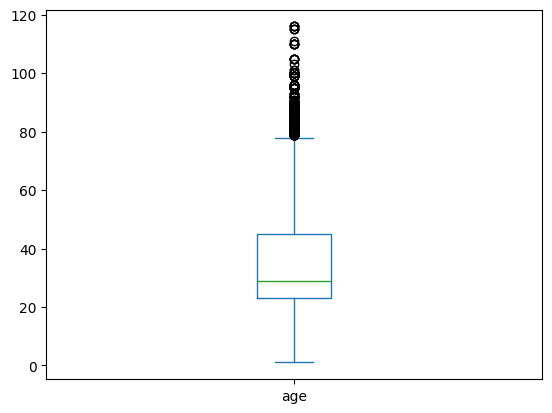

In [11]:
# checking outlier for age
df_main.age.plot(kind="box")

No outlier noted in Age column.

### 3.2 Age

##### Plotting age distribution

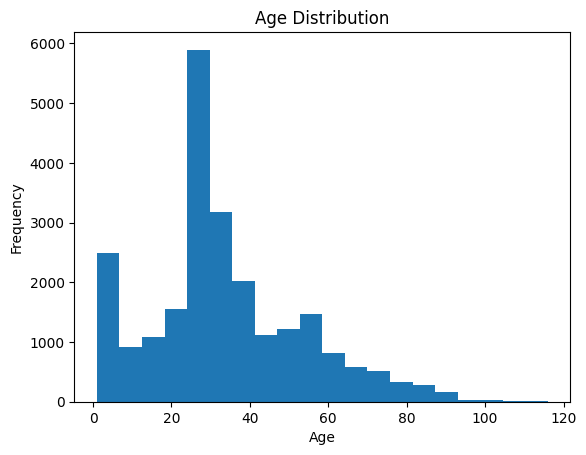

In [12]:
df_main.age.plot(kind="hist", bins = 20, title="Age Distribution", xlabel="Age");

##### Based on the histogram above, ages between mid of 20's to 40 have the highest numbers of data, followed by age 1.

##### For the age prediction model, I will utilize age group ranges instead of discrete ages. This is because it is more practical for the model to predict an age range rather than a precise age. Predicting gender and race based on appearance is relatively straightforward, but predicting age is much more challenging. At best, we can estimate someone's age within a range, such as being in their 20s or 30s. Therefore, the age prediction model will employ age ranges rather than precise ages.

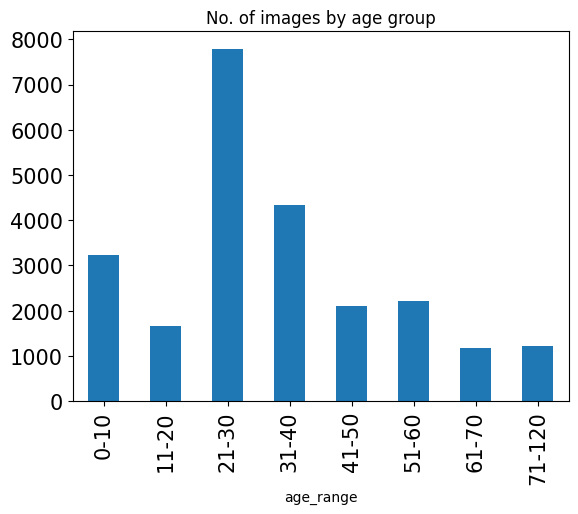

In [38]:
# plotting by age group

df_main.age_range.value_counts().sort_index().plot(kind='bar', title='No. of images by age group', fontsize=15);

##### Based on the bar chart above, age group "21-30" have the highest numbers of data, followed by "31-40" and "0-10". 

##### The following images are the random samples from each age group.

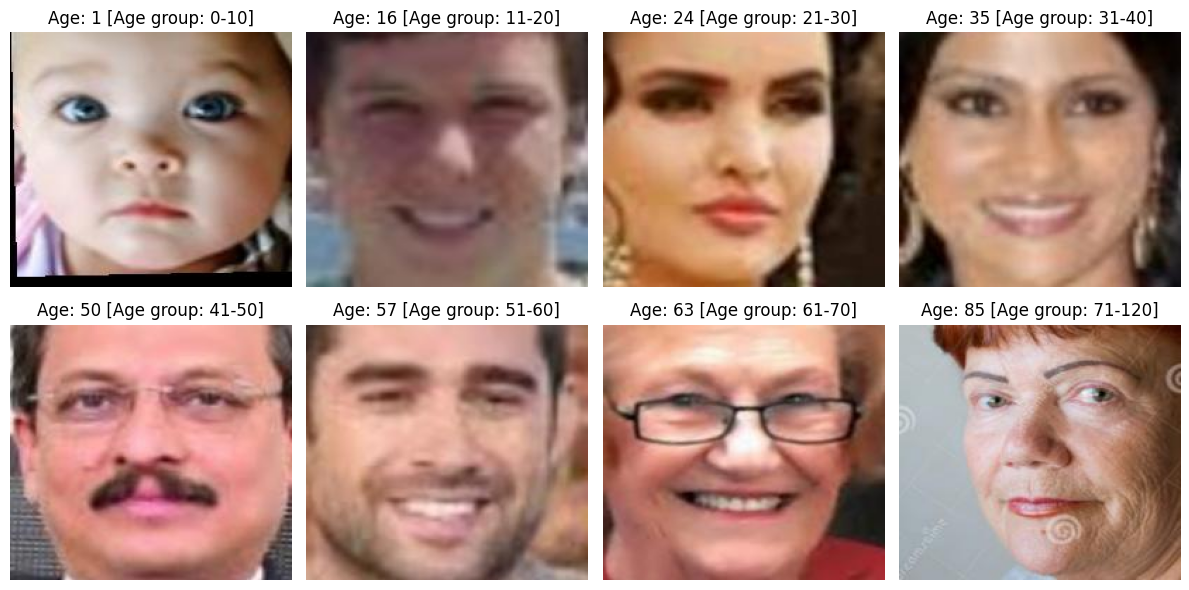

In [14]:
# set a random seed
np.random.seed(42)

# set a subplot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

#randonly choose an image from each age group
img_list = []
for group in df_main.age_range.value_counts().sort_index().index:
    img_list.append(np.random.choice(df_main[df_main.age_range == group].filename))

# Load the image
nrow = 0
ncol = 0

for num, img in enumerate(img_list):
    image = imread(os.path.join("../datasets/utkface",img))

    # Display the image
    axes[nrow, ncol].imshow(image, cmap='gray', aspect='auto')
    axes[nrow, ncol].set_title(f"Age: {list(extract_info_from_filename(img))[0]} [Age group: {df_main.loc[df_main['filename'] == img,'age_range'].values[0]}]")
    axes[nrow, ncol].axis('off')

    ncol += 1
    if ncol == 4:
        nrow += 1
        ncol = 0

plt.tight_layout()
plt.show()

---

### 3.3 Gender

##### Plotting a pie chart to check the proportion of gender

Text(0.5, 1.0, 'Proportion of Gender')

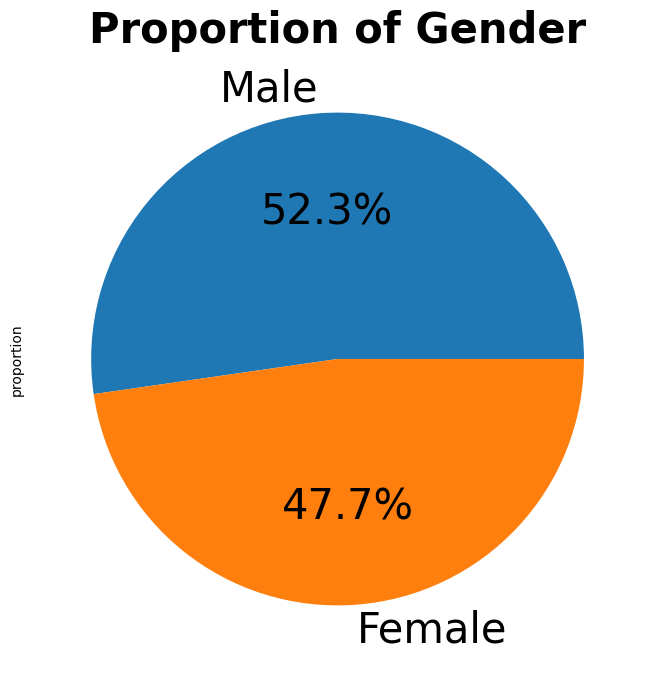

In [35]:
df_main.gender.value_counts(normalize=True).plot(kind="pie", autopct='%1.1f%%', legend=False, figsize=(8, 8), fontsize=30);
plt.title('Proportion of Gender', fontsize=30, fontweight='bold')

##### The proportion of male and female is balanced in the dataset.

##### The following images are the random samples from each genders.

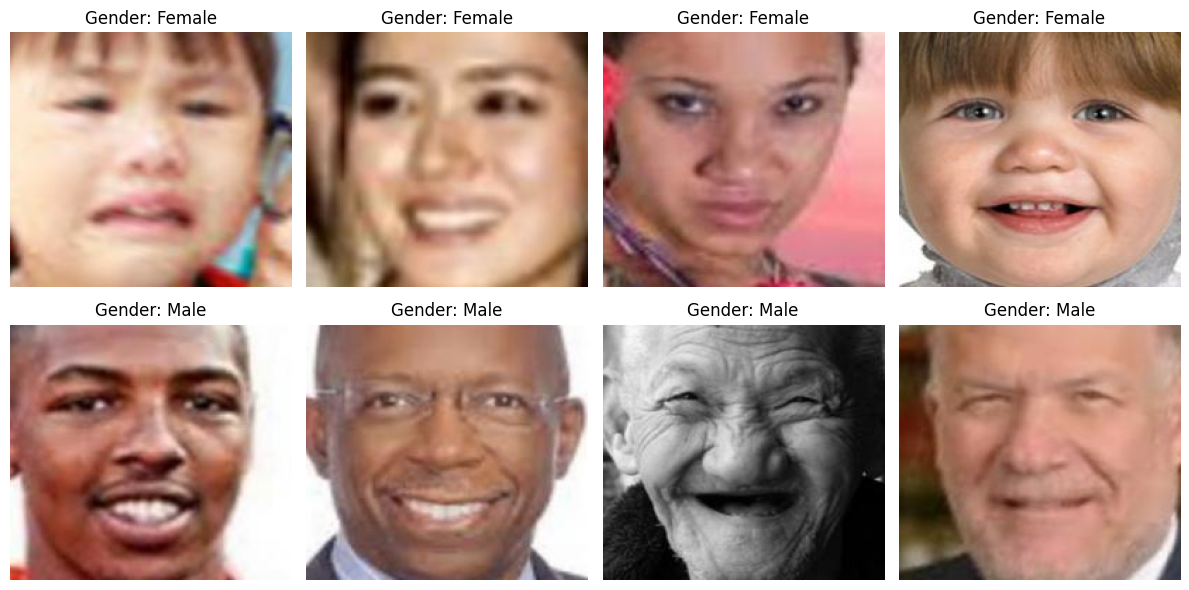

In [16]:
# set a random seed
np.random.seed(42)

# set a subplot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

#randonly choose 4 images from each gender
img_list = []
for group in df_main.gender.value_counts().sort_index().index:
    for _ in range(4):
        img_list.append(np.random.choice(df_main[df_main.gender == group].filename))

# Load the image
nrow = 0
ncol = 0

for num, img in enumerate(img_list):
    image = imread(os.path.join("../datasets/utkface",img))

    # Display the image
    axes[nrow, ncol].imshow(image, cmap='gray', aspect='auto')
    axes[nrow, ncol].set_title(f"Gender: {df_main.loc[df_main['filename'] == img,'gender'].values[0]}")
    axes[nrow, ncol].axis('off')

    ncol += 1
    if ncol == 4:
        nrow += 1
        ncol = 0

plt.tight_layout()
plt.show()

---

## 3.4 Race (Ethnicity)

##### Plotting a pie chart to check the proportion of races

Text(0.5, 1.0, 'Proportion of Races')

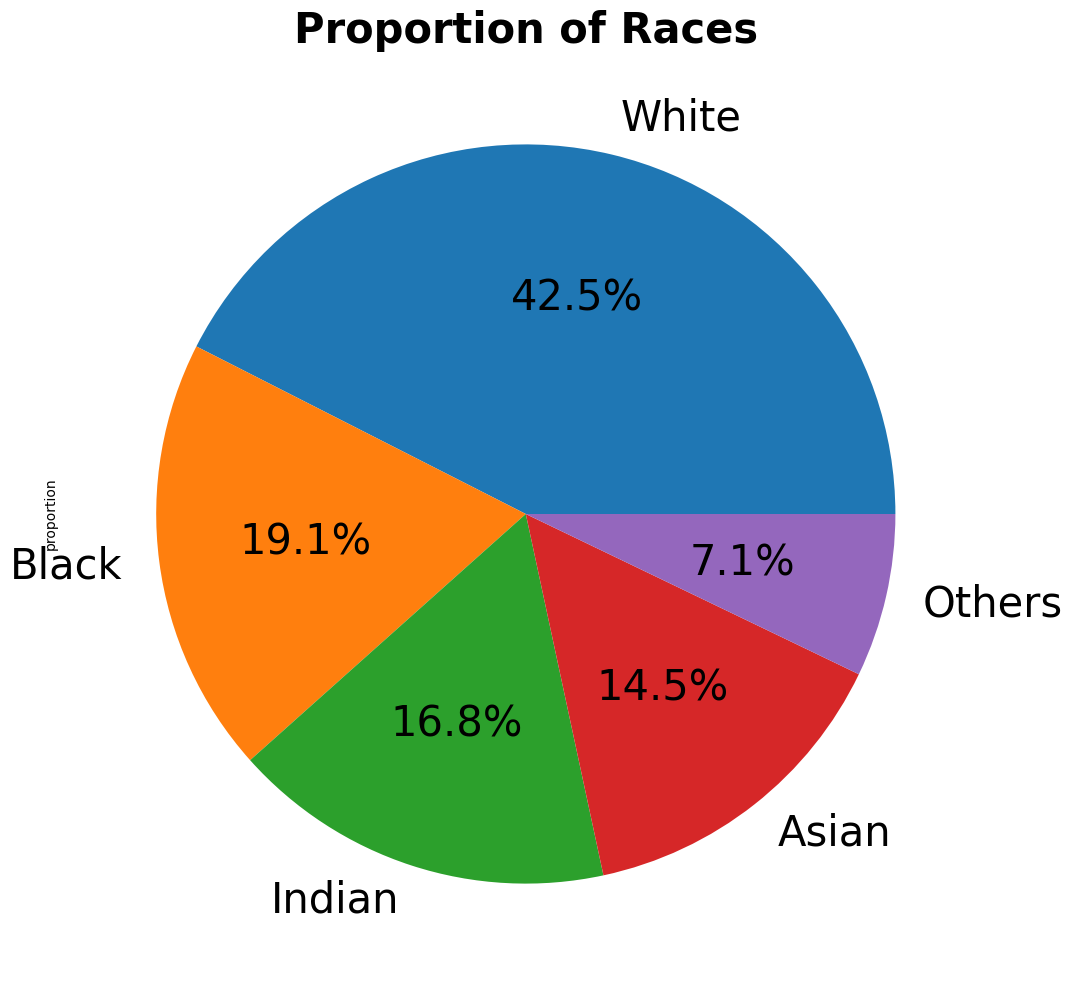

In [34]:
df_main.race.value_counts(normalize=True).plot(kind="pie", autopct='%1.1f%%', legend=False, figsize=(12, 12), fontsize=30);
plt.title('Proportion of Races', fontsize=30, fontweight='bold')

##### Based on the pie chart, it's evident that nearly half of the samples belong to the white race, suggesting a high expected accuracy within this group. Similarly, other races such as black, Indian, and Asian exhibit a substantial number of samples, indicating promising accuracy rates. Conversely, the 'others' category (including Hispanics, Latinos, etc.) displays a relatively small number of samples.

##### The following images are the random samples from each ethnicity.

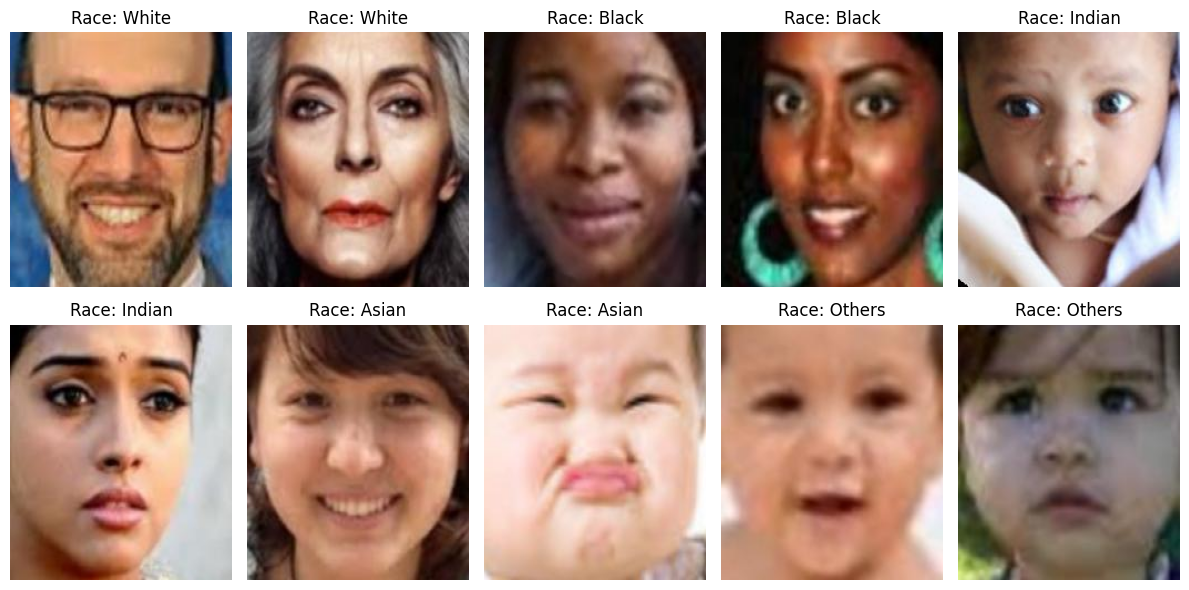

In [18]:
# set a random seed
np.random.seed(42)

# set a subplot
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

#randonly choose an image from each ethnicity
img_list = []
for group in df_main.race.value_counts().index:
    for _ in range(2):
        img_list.append(np.random.choice(df_main[df_main.race == group].filename))

# Load the image
nrow = 0
ncol = 0

for num, img in enumerate(img_list):
    image = imread(os.path.join("../datasets/utkface",img))

    # Display the image
    axes[nrow, ncol].imshow(image, cmap='gray', aspect='auto')
    axes[nrow, ncol].set_title(f"Race: {df_main.loc[df_main['filename'] == img,'race'].values[0]}")
    axes[nrow, ncol].axis('off')

    ncol += 1
    if ncol == 5:
        nrow += 1
        ncol = 0

plt.tight_layout()
plt.show()

##### We have cleaned and understand the data for UTKface. In the subsequent notebooks, we will proceed to build the prediction models for gender, race and age.